In [8]:
# Imports

import pandas as pd
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from matplotlib.ticker import MultipleLocator
import locale

from statsmodels.tsa.seasonal import MSTL

### Leitura dos Dados

In [9]:
df = pd.read_excel("../data/Desafio Inteligência (Cientista de Dados).xlsx")

### Limpeza dos Dados

In [10]:
df.categoria_veiculo = df.categoria_veiculo.replace(
    {"IntermediÃ¡rio": "Intermediário", "EconÃ´mico": "Econômico"}
)

for column_name in df.columns:
    if "Unnamed" in column_name:
        df.drop(column_name, axis=1, inplace=True)

df.drop(["cidade", "estado"], axis=1, inplace=True)

df.id_loja = df.id_loja.str.replace("LJ_", "Loja ")

rename_columns = {
    "data_inicio_locacao": "Data de Início da Locação",
    "duracao_locacao": "Duração da Locação",
    "dias_antecedencia": "Dias de Antecedência",
    "diaria_media": "Diária Média",
    "valor_total_locacao": "Valor Total da Locação",
    "id_loja": "ID da Loja",
    "id_contrato": "ID do Contrato",
    "categoria_veiculo": "Categoria do Veículo",
}

df.rename(columns=rename_columns, inplace=True)

numerical_columns = [
    "Duração da Locação",
    "Dias de Antecedência",
    "Diária Média",
    "Valor Total da Locação",
]
categorical_columns = ["ID da Loja", "ID do Contrato", "Categoria do Veículo"]

### Estatísticas Gerais

1. Qual a duração média de uma locação?
R: 6 dias

2. Qual o valor médio arrecadado por contrato?
R$ 761.95

3. Com quantos dias de antecedência, em média, os clientes reservam?
R: 15 dias


In [11]:
# Display Dataframe
# Visualização das principais estatísticas do conjunto de dados

display(df.head())
display(df.info())
display(df.describe())

,ID do Contrato,Data de Início da Locação,Duração da Locação,ID da Loja,Dias de Antecedência,Categoria do Veículo,Diária Média,Valor Total da Locação
0,CTR0000001,2022-01-27,8,Loja 01,13,Econômico,91.22,729.76
1,CTR0000002,2022-01-31,9,Loja 01,9,Intermediário,78.70,708.30
2,CTR0000003,2022-01-10,7,Loja 01,16,SUV,143.14,1001.98
3,CTR0000004,2022-01-28,7,Loja 01,4,Intermediário,135.86,951.02
4,CTR0000005,2022-01-28,9,Loja 01,9,Intermediário,104.02,936.18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140249 entries, 0 to 140248
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ID do Contrato             140249 non-null  object        
 1   Data de Início da Locação  140249 non-null  datetime64[ns]
 2   Duração da Locação         140249 non-null  int64         
 3   ID da Loja                 140249 non-null  object        
 4   Dias de Antecedência       140249 non-null  int64         
 5   Categoria do Veículo       140249 non-null  object        
 6   Diária Média               140249 non-null  float64       
 7   Valor Total da Locação     140249 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 8.6+ MB


None

,Data de Início da Locação,Duração da Locação,Dias de Antecedência,Diária Média,Valor Total da Locação
count,140249,140249.000000,140249.000000,140249.000000,140249.000000
mean,2023-03-13 18:31:13.553465600,6.347439,15.019287,120.045161,761.950563
min,2022-01-01 00:00:00,1.000000,0.000000,-5.190000,-31.140000
25%,2022-08-01 00:00:00,5.000000,7.000000,99.750000,516.800000
50%,2023-02-24 00:00:00,6.000000,15.000000,120.140000,728.560000
75%,2023-11-03 00:00:00,8.000000,23.000000,140.220000,970.740000
max,2024-06-30 00:00:00,16.000000,30.000000,259.860000,2875.800000
std,NaN,2.271802,8.943597,30.002451,339.808277


### Histogramas

/tmp/ipykernel_488894/2659156384.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


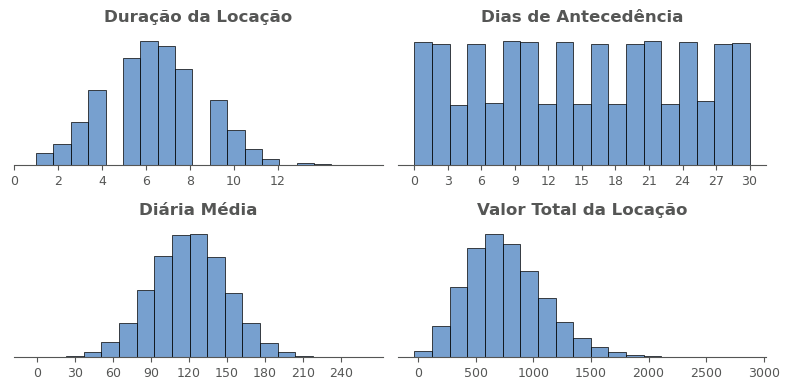

In [66]:
# Auxiliary Functions


def sturges_bins(x):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = len(x)
    if n <= 1:
        return 1, np.inf

    k = math.ceil(math.log2(n)) + 1
    data_range = x.max() - x.min()
    h = data_range / k if data_range > 0 else np.inf
    return k, h


def configure_plot(ax, title_text):
    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    plt.setp(ax.get_xticklabels(), fontsize=9, color="#555655")
    ax.get_yaxis().set_visible(False)

    ax.set_xlabel("")
    ax.set_ylabel("")
    # Título
    ax.text(
        0.5,
        1.1,
        title_text,
        transform=ax.transAxes,
        fontsize=12,
        fontweight="semibold",
        color="#555655",
        ha="center",  # centraliza horizontalmente
    )

    plt.tight_layout()


# Plot

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 4), constrained_layout=True)
axes = axes.flatten()

for idx, col in enumerate(numerical_columns):
    k, h = sturges_bins(df.loc[:, col].values)
    sns.histplot(data=df, x=col, ax=axes[idx], bins=k, binwidth=h, linewidth=0.5, color="#4A81BF")

    if col == "Duração da Locação":
        axes[idx].set_xticks(range(0, 14, 2))
    elif col == "Dias de Antecedência":
        axes[idx].set_xticks(range(0, 31, 3))
    elif col == "Diária Média":
        axes[idx].set_xticks(range(0, 251, 30))

    configure_plot(ax=axes[idx], title_text=col)

plt.savefig("../img/results/histograms.png", dpi=600)

### Gráficos de Barra

/tmp/ipykernel_488894/1474769750.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_488894/1474769750.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


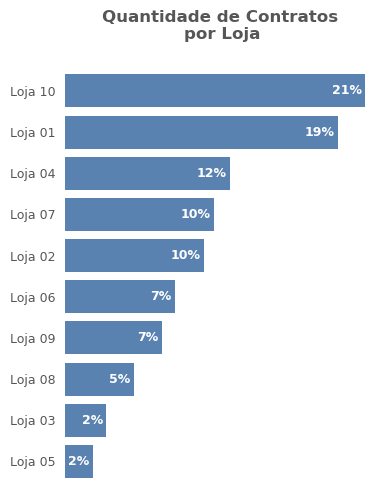

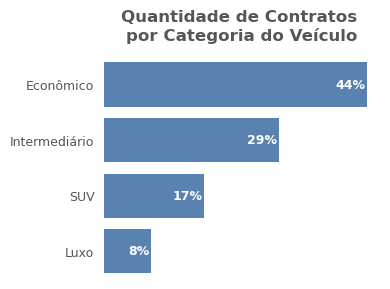

In [ ]:
# Auxiliary Functions


def configure_plot(ax, title_text):
    ax.tick_params(color="#555655")
    ax.spines["left"].set_color("#555655")
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.setp(ax.get_yticklabels(), fontsize=9, color="#555655")
    ax.get_xaxis().set_visible(False)
    ax.tick_params(left=False)

    ax.set_xlabel("")
    ax.set_ylabel("")
    # Título
    ax.text(
        0.5,
        1.075,
        title_text,
        transform=ax.transAxes,
        fontsize=12,
        fontweight="semibold",
        color="#555655",
        ha="center",
    )

    for p in ax.patches:
        percent = int(p.get_width() * 100)
        text = f"{percent}%"

        x = p.get_width() - 0.0025
        y = p.get_y() + p.get_height() / 2

        ax.text(
            x,
            y,
            text,
            fontweight="semibold",
            ha="right",
            va="center",
            fontsize=9,
            color="white",
        )

    plt.tight_layout()


# Plot

for col in categorical_columns:
    if col != "ID do Contrato":
        if col == "ID da Loja":
            title_text = "Percentual de Contratos \npor Loja"
            file_name = "store"
            fig, ax = plt.subplots(figsize=(4, 5), constrained_layout=True)
        else:
            title_text = "Percentual de Contratos \npor " + col
            file_name = "vehicle_category"
            fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)

        rel_freq = df[col].value_counts(normalize=True).reset_index()
        rel_freq.columns = [col, "percent"]

        order = rel_freq[col]

        sns.barplot(
            data=rel_freq,
            y=col,
            x="percent",
            order=order,
            ax=ax,
            linewidth=1,
            color="#4A81BF",
        )

        configure_plot(ax=ax, title_text=title_text)

        plt.savefig(f"../img/results/contracts_by_{file_name}.png", dpi=300)

### Análise Temporal